In [1]:
#General libraries
import pandas as pd
import numpy as np

#Data processing and models
from sklearn.model_selection import StratifiedKFold, cross_val_score
import xgboost as xgb

#Plots
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

#Misc libs
import os
import math

%matplotlib inline

In [2]:
PATH = os.getcwd()
trainRaw = pd.read_csv(os.path.join(PATH,"train.csv"))
testRaw = pd.read_csv(os.path.join(PATH,"test.csv"))

# 1. Data description

Quick look at the data to explore the types of variables, their stats (max, min, etc.), number of missing values and whether the dataset is balanced. 

In [3]:
#Exploring the train set
trainSet = trainRaw.copy(deep=True)
trainSet.head(10)

,idx,time_to_first_matter,time_to_first_time_entry,time_to_first_bill,time_to_second_user,page_views_in_first_hour,page_views_in_first_day,page_views_in_first_7_days,page_views_in_first_14_days,time_to_conversion,conversion_value
0,745,NaN,NaN,NaN,NaN,12.0,12.0,12.0,12.0,NaN,NaN
1,1190,117.0,117.0,223.0,280881.0,16.0,16.0,31.0,31.0,281245.0,140.0
2,1242,351.0,448.0,NaN,NaN,20.0,20.0,20.0,20.0,NaN,NaN
3,1044,NaN,NaN,NaN,NaN,1.0,5.0,5.0,5.0,NaN,NaN
4,304,NaN,NaN,NaN,NaN,4.0,4.0,4.0,4.0,NaN,NaN
5,843,1190696.0,1190448.0,1191054.0,NaN,7.0,7.0,13.0,59.0,591962.0,69.0
6,936,278.0,355.0,NaN,NaN,10.0,10.0,10.0,10.0,NaN,NaN
7,997,NaN,NaN,NaN,1168.0,41.0,89.0,89.0,89.0,1973.0,828.0
8,110,NaN,NaN,NaN,NaN,22.0,22.0,24.0,24.0,NaN,NaN
9,871,NaN,332.0,NaN,NaN,10.0,20.0,20.0,20.0,NaN,NaN


In [4]:
trainSet.tail(10)

,idx,time_to_first_matter,time_to_first_time_entry,time_to_first_bill,time_to_second_user,page_views_in_first_hour,page_views_in_first_day,page_views_in_first_7_days,page_views_in_first_14_days,time_to_conversion,conversion_value
990,168,96794.0,NaN,NaN,NaN,21.0,21.0,62.0,62.0,NaN,NaN
991,1228,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,NaN,NaN
992,73,1150.0,1150.0,1150.0,NaN,30.0,54.0,136.0,227.0,NaN,NaN
993,598,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.0,NaN,NaN
994,720,103.0,NaN,NaN,NaN,20.0,20.0,32.0,42.0,1043207.0,62.1
995,1191,NaN,NaN,NaN,147.0,32.0,32.0,40.0,43.0,1348.0,124.2
996,309,136.0,NaN,NaN,NaN,3.0,3.0,3.0,3.0,NaN,NaN
997,530,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,NaN,NaN
998,273,NaN,NaN,NaN,NaN,5.0,5.0,5.0,5.0,NaN,NaN
999,270,NaN,NaN,NaN,NaN,1.0,1.0,5.0,5.0,NaN,NaN


In [5]:
print("Data types are:\n", trainSet.dtypes)

Data types are:
 idx                              int64
time_to_first_matter           float64
time_to_first_time_entry       float64
time_to_first_bill             float64
time_to_second_user            float64
page_views_in_first_hour       float64
page_views_in_first_day        float64
page_views_in_first_7_days     float64
page_views_in_first_14_days    float64
time_to_conversion             float64
conversion_value               float64
dtype: object


In [6]:
trainSet.describe().T

,count,mean,std,min,25%,50%,75%,max
idx,1000.0,648.075000,369.840213,2.00,326.50,658.5,970.25,1283.0
time_to_first_matter,444.0,125224.853604,254762.378109,48.00,437.25,1955.5,89674.50,1190696.0
time_to_first_time_entry,365.0,131241.605479,255418.152143,15.00,551.00,2819.0,151014.00,1208042.0
time_to_first_bill,181.0,205680.397790,301326.676331,217.00,1239.00,16591.0,342753.00,1204219.0
time_to_second_user,116.0,188593.612069,315468.784845,79.00,491.00,4414.0,310103.25,1198713.0
page_views_in_first_hour,972.0,20.176955,23.054933,1.00,5.00,13.0,26.00,149.0
page_views_in_first_day,972.0,38.403292,68.856677,1.00,7.00,16.0,38.00,673.0
page_views_in_first_7_days,972.0,75.997942,163.458571,1.00,8.00,20.0,66.25,1813.0
page_views_in_first_14_days,972.0,112.877572,279.545881,1.00,9.00,22.0,88.25,3532.0
time_to_conversion,171.0,398793.473684,357437.607509,132.00,14244.00,406343.0,606905.50,1204386.0


Observations:
- Imbalanced dataset, ~20% converted: Will use stratified folds for cross validation and AUC for metric
- Many missing values in first 4 columns (up to ~80% for time_to_first_bill and time_to_second_user). Although absence of values is sign of possible churn, maybe adding a binary columns may be useful.
- Need to check for outliers 

# 2. Variable correlations

Exploring the relationship between variables using correlation matrix and scatter plots. 

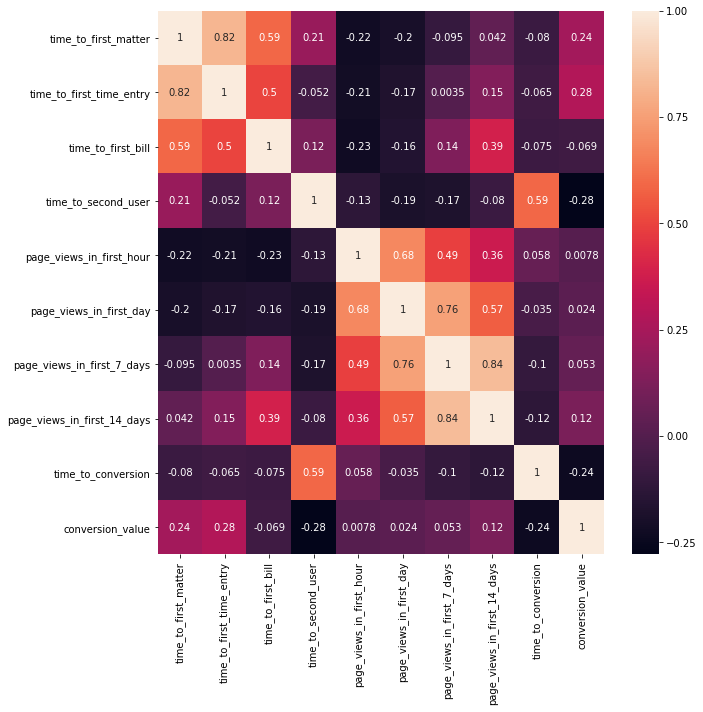

In [7]:
#Correlations
corrSet = trainSet.drop(['idx'],axis=1)
corr = corrSet.corr()

#Heatmap
plt.figure(figsize=(10,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

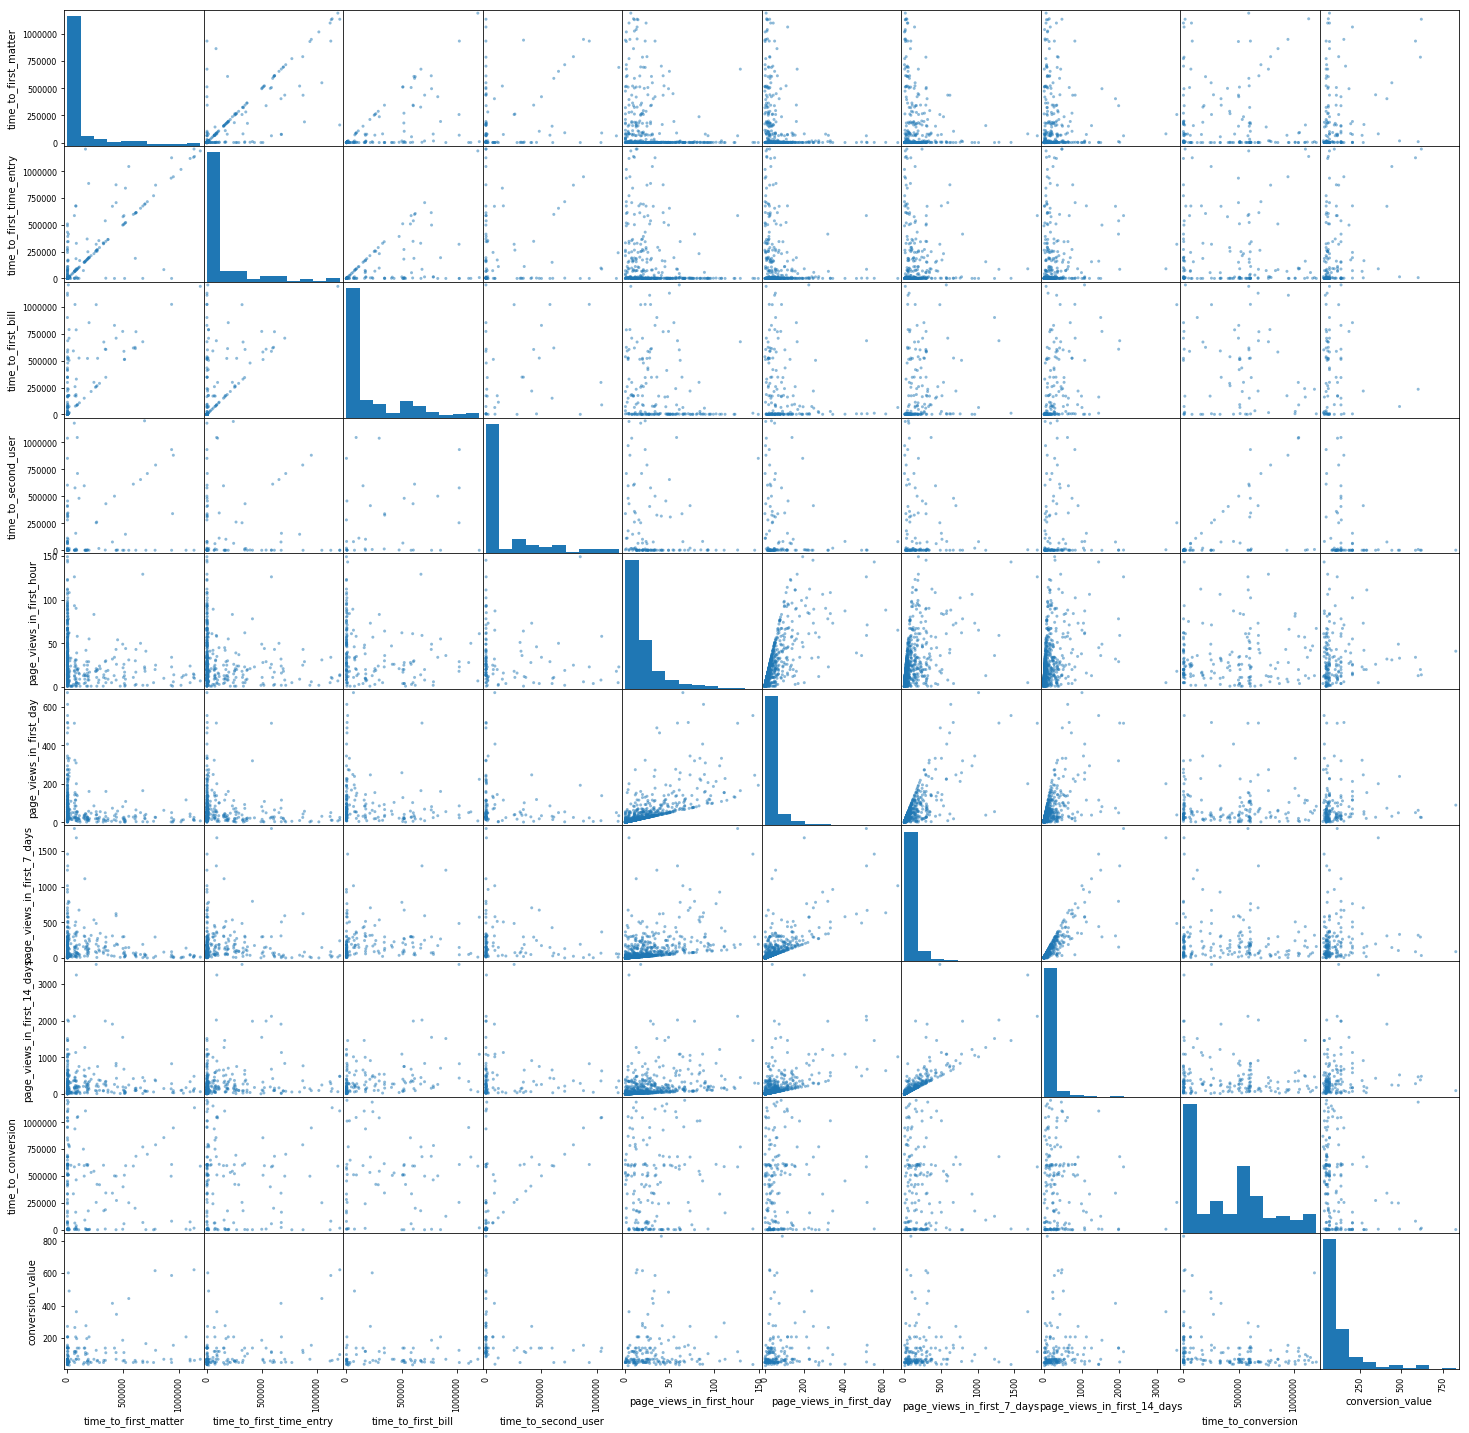

In [8]:
#Another look at correlations through a scatter matrix
scatter_matrix(corrSet, figsize=(25, 25))
plt.show()

Observations:
- time_to_conversion and time_to_second_user seem to be moderately correlated (r=0.59) which would make sense as adding a second user can be sign of more interest in adopting the product. 
- Strongest positive correlation among page view variables is between 7 days to 14 days (0.84) followed by 1st day to 7 days (0.76), first hour and first day are close too: Technically can keep only 1 of those columns, 14 days would be good as a cumulative sum of page views. 
- Among first goals time_to_first_matter and first_time_entry seem to be strongly related (0.82), time_to_first_bill is close to the former to (0.59). Can drop time_to_first_matter. 
<br> Note: Dropping the columns for the similicity of the model with understanding that these still may be important during customer onboarding, e.g. if within 7 days there is no activity by customers sales team may reach out to them to motivate product usage.
- There seem to be a low negative relationship between converstion_value and time_to_conversion (-0.24), but it is difficult to say if that will be of any use for predicting conversion. At this time excluding conversion_value as predicting that can be a seperate model in itself.

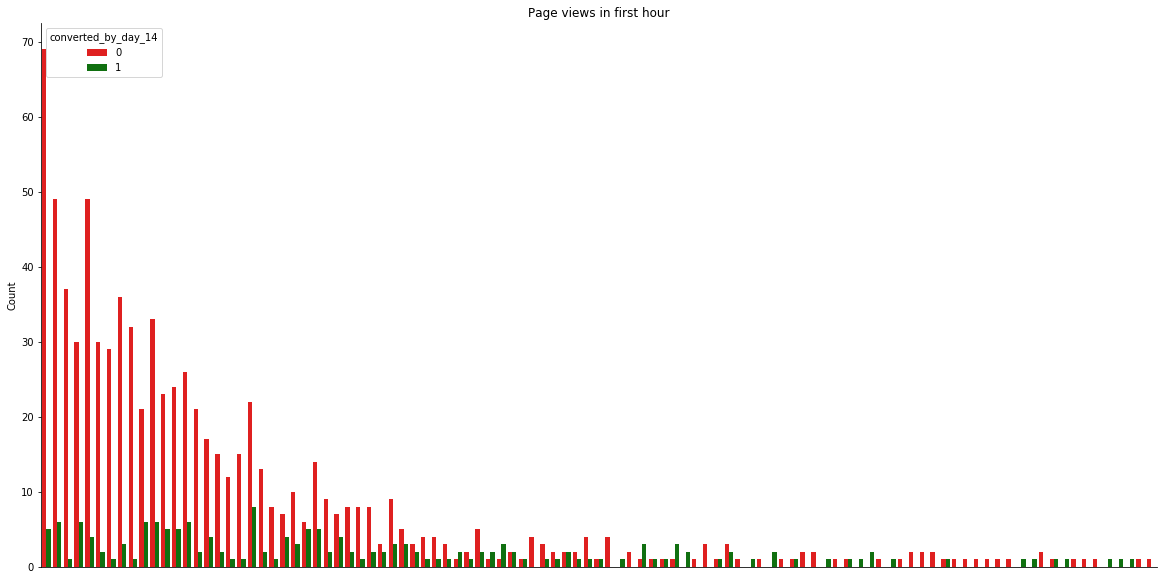

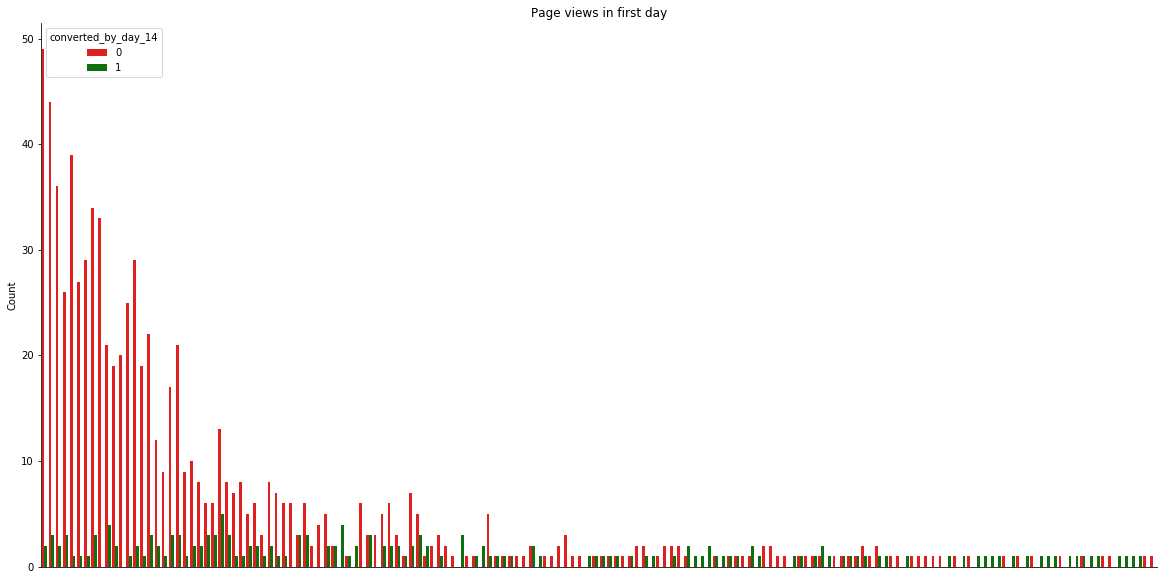

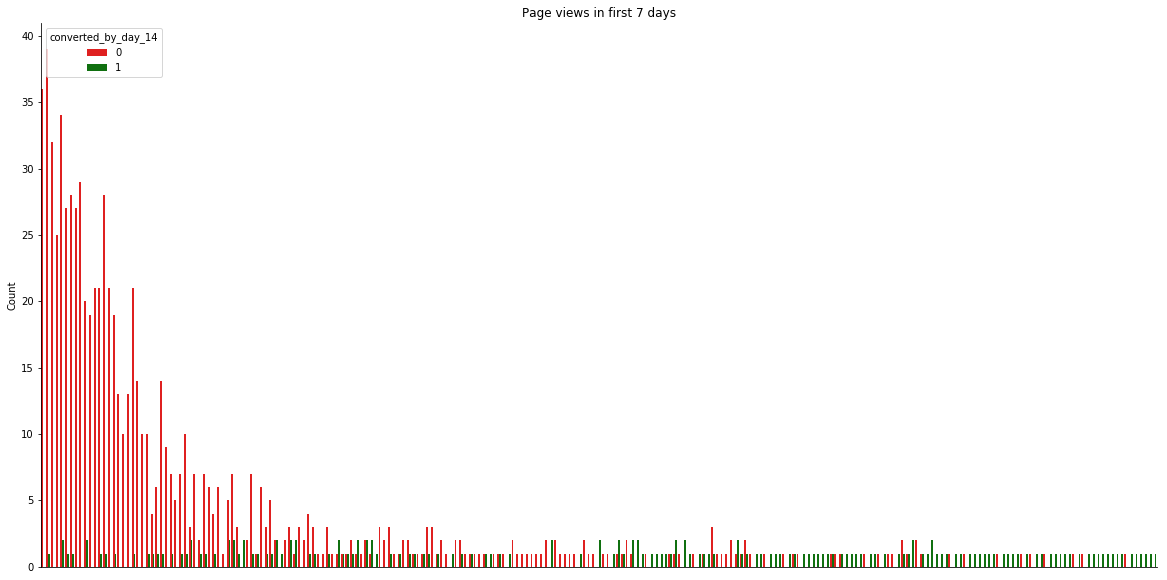

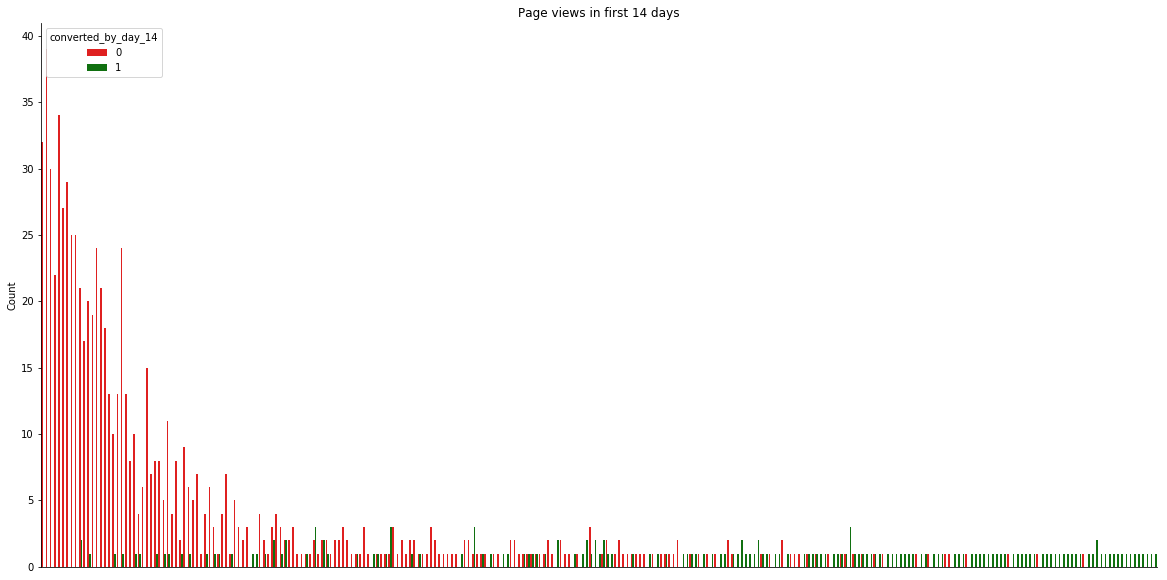

In [9]:
#Closer look at distribution for page views before dropping columns
#Making time_to_coversion binary for plotting
trainSet["converted_by_day_14"] = trainSet["time_to_conversion"].apply(lambda x: 0 if np.isnan(x) else 1)
for col in trainSet.columns:
    if "page_views" in col:
        plt.figure(figsize=(20,10))
        ax = sns.countplot(data=trainSet, x=col, hue="converted_by_day_14", palette=["red","green"])
        sns.despine()
        
        ax.set_xticks([])
        plt.title(col.replace("_", " ").capitalize())
        ax.set(xlabel='', ylabel='Count')
        plt.show()

From a quick look nothing is standing out, will go ahead and drop first hour, day and 7 days.

# 3.Predicting conversions on test set

In [10]:
def processData(df):
    """
    This function processes train/test data
    Input: Raw dataframe
    Output: Processed dataframe, customer ids
    """
    
    #Convert target to binary for train set
    if "time_to_conversion" in df.columns:
        df["converted_by_day_14"] = df["time_to_conversion"].apply(lambda x: 0 if np.isnan(x) else 1)
        df = df.drop(['conversion_value', #seperate prediction task on its own
                     'time_to_conversion'], #has been added as binary column
                      axis=1, inplace=True)
    #Seperating ids
    ids = df['idx']
    
    #Dropping columns
    dfProc = df.drop(['idx',
               'time_to_first_matter', #high correlation to first entry
               'page_views_in_first_hour','page_views_in_first_day','page_views_in_first_7_days'], #high corr with 14 days
                axis=1)

    #TODO: Imputing missing values - the library I will be using (XGBoost) can handle missing values
    #But otherwise sklearn.preprocessing.Imputer would have been of use
    
    #TODO:Checking for outliers and scaling/normalizing data
    
    print("Final size ", dfProc.shape)
    print(dfProc.head())
    
    return dfProc, ids

In [12]:
procTrainSet, trainIds = processData(trainRaw)

Final size  (1000, 5)
   time_to_first_time_entry  time_to_first_bill  time_to_second_user  \
0                       NaN                 NaN                  NaN   
1                     117.0               223.0             280881.0   
2                     448.0                 NaN                  NaN   
3                       NaN                 NaN                  NaN   
4                       NaN                 NaN                  NaN   

   page_views_in_first_14_days  converted_by_day_14  
0                         12.0                    0  
1                         31.0                    1  
2                         20.0                    0  
3                          5.0                    0  
4                          4.0                    0  


In [13]:
procTestSet, testIds = processData(testRaw)

Final size  (100, 4)
   time_to_first_time_entry  time_to_first_bill  time_to_second_user  \
0                       NaN                 NaN                330.0   
1                       NaN                 NaN                  NaN   
2                       NaN                 NaN                  NaN   
3                       NaN                 NaN                  NaN   
4                  244990.0                 NaN                  NaN   

   page_views_in_first_14_days  
0                         56.0  
1                         18.0  
2                         21.0  
3                         58.0  
4                        150.0  


In [14]:
#Split data, since data are imbalanced using stratified k-fold
y_train = procTrainSet['converted_by_day_14']
X_train = procTrainSet.drop('converted_by_day_14', axis=1)
strkfold = StratifiedKFold(n_splits=5, random_state=1)

In [15]:
#Classification model with XGboost
print("Building a classification model")
model_cls = xgb.XGBClassifier(seed=1)
model_cls.fit(X_train, y_train, eval_metric='auc')

result = cross_val_score(model_cls, X_train, y_train, cv=strkfold, scoring='roc_auc')
print("roc_auc is", round(result.mean(),2))

Building a classification model
roc_auc is 0.93


[0.24105461 0.14124294 0.259887   0.35781544]


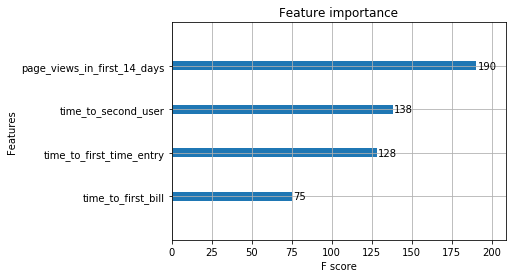

In [16]:
#Print the importance of features
print(model_cls.feature_importances_)
xgb.plot_importance(model_cls)

In [17]:
#Predict on test set
preds = pd.concat([testIds, pd.Series(model_cls.predict(procTestSet))], axis=1)
preds.rename(columns={0:'converted_by_day_14'}, inplace=True)
preds.head()

,idx,converted_by_day_14
0,480,1
1,285,0
2,1106,0
3,688,0
4,137,0


In [18]:
#Export results
preds.to_csv("testSetPredictions.csv", index=False)

# 4. Insights, experiments and suggestions for integrating into the product development and sales

Though dataset is relatively small to place much confidence in the model (AUC of 0.93 is a bit too good to be true), main insights acquired from the model above is that page views matter the most followed by time to second user. 
Not implemented here, but if there was more time, I would start adding 1 hour, 1 day, 7 days to dataset one by one to see how those affect the results.
<br> It would also be interesting to find out what would be the "threshold" for page views from which conversion happens. One way to do this adding a new variable that splits page views into buckets, e.g. 0-50 low, 50-100 medium etc. and find the most optimal bucket overtime that contains most converting customers. These can be integrated into the product in form of alerts to notify sales team that certain customers are below that range of page views to help prioritize outreach. 
<br> the second variable, time_to_second_user, that the model found important was in line with initial observation from correlation matrix to be related to conversion. 
<br> The conversion value was left unexplored, the approach I would have taken would be building a regression model with target of conversion value.
